In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
# Imports & config -----------------------------------------------------------
from pathlib import Path
from typing import Callable, Tuple
import json, os, joblib, numpy as np, pandas as pd, shap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from tensorflow import keras
from tensorflow.keras import layers
try:
    import pyarrow.parquet as pq  # optional speed‑up
except ModuleNotFoundError:
    pq = None

DATA_DIR = Path("/kaggle/input/ieee-fraud-detection")
RAND      = 42
VAL_FRAC  = 0.10
ALERT_Q   = 0.003
ARTIFACTS = Path("./artefacts").resolve(); ARTIFACTS.mkdir(exist_ok=True, parents=True)

2025-07-26 19:59:12.660153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753559952.929287      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753559953.012605      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Data loading & basic cleaning helpers -------------------------------------

def _read(fp: Path) -> pd.DataFrame:
    """Read CSV or Parquet and normalise any `id-xx` columns to `id_xx`."""
    if fp.suffix == ".parquet" and pq is not None:
        df = pq.read_table(fp).to_pandas()
        df.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in df.columns]
        return df

    df = pd.read_csv(fp)
    if any(c.startswith("id-") for c in df.columns):
        df.columns = [c.replace("id-", "id_") if c.startswith("id-") else c for c in df.columns]
    return df

def load_raw() -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_fp = next(DATA_DIR.glob("train_transaction.*"))
    test_fp  = next(DATA_DIR.glob("test_transaction.*"))
    train, test = _read(train_fp), _read(test_fp)
    id_train_fp = DATA_DIR / f"train_identity{train_fp.suffix}"
    if id_train_fp.exists():
        train_id = _read(id_train_fp)
        test_id  = _read(DATA_DIR / f"test_identity{train_fp.suffix}")
        train = train.merge(train_id, on="TransactionID", how="left")
        test  = test.merge(test_id,  on="TransactionID", how="left")
    return train, test


def clean(train: pd.DataFrame, test: pd.DataFrame):
    cat_cols = [c for c in train.columns if train[c].dtype == "object"]
    for c in cat_cols:
        train[c] = train[c].astype("string")
        if c in test.columns:
            test[c] = test[c].astype("string")

    for c in cat_cols:
        rare = train[c].value_counts(dropna=False)
        rare = rare[rare < 10].index
        train[c] = train[c].replace(rare, "__RARE__")
        if c in test.columns:
            test[c] = test[c].replace(rare, "__RARE__")

    train[cat_cols] = train[cat_cols].fillna("__NA__")
    common_cat = [c for c in cat_cols if c in test.columns]
    test[common_cat] = test[common_cat].fillna("__NA__")

    num_cols = [c for c in train.columns if c not in cat_cols + ["isFraud"]]
    train[num_cols] = train[num_cols].fillna(-999.0)
    test[num_cols]  = test[num_cols].fillna(-999.0)

    if any(col.startswith("id-") for col in test.columns):
        test.columns = [col.replace("id-", "id_") if col.startswith("id-") else col for col in test.columns]

    return cat_cols, num_cols


def time_val_split(df: pd.DataFrame):
    cutoff = df["TransactionDT"].quantile(1 - VAL_FRAC)
    return df[df["TransactionDT"] < cutoff].copy(), df[df["TransactionDT"] >= cutoff].copy()


In [4]:
# Feature‑matrix builder -----------------------------------------------------

def build_matrix(train, valid, test, cat_cols, num_cols):
    tr_cat, va_cat, te_cat = [], [], []
    for c in cat_cols:
        freq = train[c].value_counts(dropna=False, normalize=True)
        enc = lambda s: s.map(freq).fillna(0.).to_numpy("float32")[:, None]
        tr_cat.append(enc(train[c])); va_cat.append(enc(valid[c])); te_cat.append(enc(test[c]))
    scaler = StandardScaler().fit(train[num_cols])
    tr_num = scaler.transform(train[num_cols]).astype("float32")
    va_num = scaler.transform(valid[num_cols]).astype("float32")
    te_num = scaler.transform(test[num_cols]).astype("float32")
    return np.hstack(tr_cat + [tr_num]), np.hstack(va_cat + [va_num]), np.hstack(te_cat + [te_num])

In [5]:
# %%
# Evaluation helper ----------------------------------------------------------

def evaluate(name: str, score_fn: Callable[[np.ndarray], np.ndarray], X_va, y_va, X_te, txid):
    va_score = score_fn(X_va)
    thr = np.quantile(va_score, 1 - ALERT_Q)
    va_pred = (va_score >= thr).astype(int)
    metrics = dict(
        accuracy = accuracy_score(y_va, va_pred),
        precision= precision_score(y_va, va_pred, zero_division=0),
        recall   = recall_score(y_va, va_pred, zero_division=0),
        f1       = f1_score(y_va, va_pred, zero_division=0),
        roc_auc  = roc_auc_score(y_va, va_score),
        pr_auc   = average_precision_score(y_va, va_score),
        threshold= float(thr),
    )
    print(f"[{name}] " + "  ".join(f"{k}={v:.4f}" for k,v in metrics.items()))
    with open(ARTIFACTS / f"{name}_metrics.json", "w") as fp: json.dump(metrics, fp, indent=2)

    prob = (score_fn(X_te) - va_score.min()) / (va_score.max() - va_score.min() + 1e-9)
    pd.DataFrame({"TransactionID": txid, "isFraud": prob}).to_csv(ARTIFACTS / f"{name}_submission.csv", index=False)


In [6]:
def train_kmeans(X, k=100):
    pca = PCA(n_components=50, random_state=RAND).fit(X)
    km = MiniBatchKMeans(n_clusters=k, batch_size=4096, random_state=RAND).fit(pca.transform(X))
    return pca, km

In [7]:
# Build data once -----------------------------------------------------------
train_raw, test_raw = load_raw()
cat_cols, num_cols  = clean(train_raw, test_raw)
train_df, valid_df  = time_val_split(train_raw)

X_tr, X_va, X_te = build_matrix(train_df, valid_df, test_raw, cat_cols, num_cols)
y_va             = valid_df["isFraud"].astype(int).values
txid_te          = test_raw["TransactionID"].values


In [8]:
pca, km = train_kmeans(X_tr)
evaluate("kmeans", lambda X: km.transform(pca.transform(X)).min(axis=1), X_va, y_va, X_te, txid_te)

The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


[kmeans] accuracy=0.9595  precision=0.0000  recall=0.0000  f1=0.0000  roc_auc=0.7055  pr_auc=0.0674  threshold=821.6089


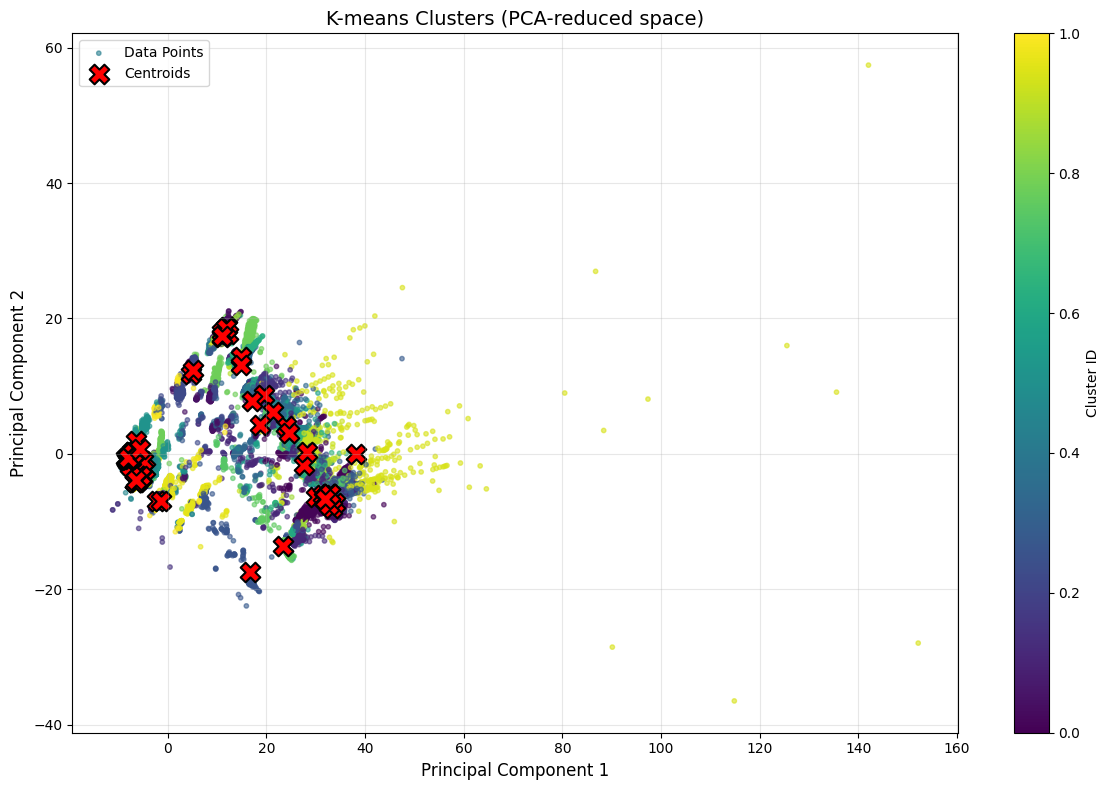

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Transform data to 2D PCA space
X_pca = pca.transform(X_tr)[:, :2]  # Original data -> PCA space

# Get cluster assignments and centroids
labels = km.labels_

# CORRECTED: Centroids are already in PCA space - just take first 2 dimensions
centroids = km.cluster_centers_[:, :2]  # Directly use cluster centers

# Plot clusters
plt.figure(figsize=(12, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=labels, cmap='viridis', 
            s=10, alpha=0.6, 
            label='Data Points')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='red', marker='X', s=200,
            edgecolor='black', linewidth=1.5,
            label='Centroids')

plt.title('K-means Clusters (PCA-reduced space)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.colorbar(label='Cluster ID')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(ARTIFACTS / "kmeans_clusters.png", dpi=120)
plt.show()

K=50, Inertia=53172880.00
K=100, Inertia=36441200.00
K=150, Inertia=39858572.00
K=200, Inertia=25091484.00
K=250, Inertia=37952568.00
K=300, Inertia=23922038.00
K=350, Inertia=24273856.00


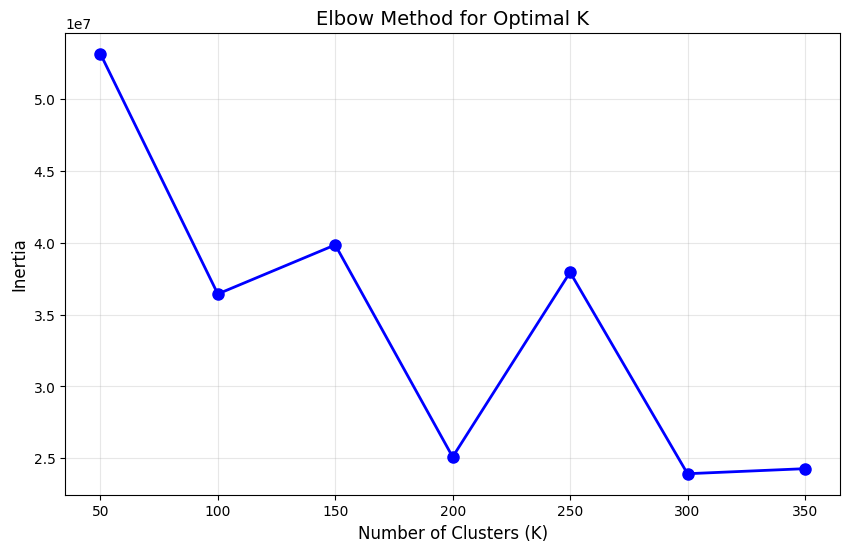

In [11]:
from sklearn.cluster import MiniBatchKMeans

# Use PCA-transformed data for elbow method
X_pca_full = pca.transform(X_tr)  # Transform to PCA space

# Test different K values
k_values = range(50, 351, 50)
inertias = []

for k in k_values:
    km_test = MiniBatchKMeans(n_clusters=k, 
                             batch_size=4096,
                             random_state=RAND,
                             n_init=3).fit(X_pca_full)
    inertias.append(km_test.inertia_)
    print(f"K={k}, Inertia={inertias[-1]:.2f}")

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Elbow Method for Optimal K', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(k_values)
plt.savefig(ARTIFACTS / "kmeans_elbow_curve.png", dpi=120)
plt.show()